In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data 

In [16]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)

len(dataset)

2300

In [25]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [26]:
num_classes = len(dataset.classes)
num_classes

6

In [27]:

train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1725, 575)

In [28]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [30]:
for images,labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [42]:
type(images), type(labels) , type(images[0]), type(labels[0]) , type(train_dataset), type(train_loader)

(torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataloader.DataLoader)

In [43]:
images[0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [45]:
labels[0]

tensor(4)

In [46]:
images[0].shape

torch.Size([3, 224, 224])

In [47]:
images[0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8556864].


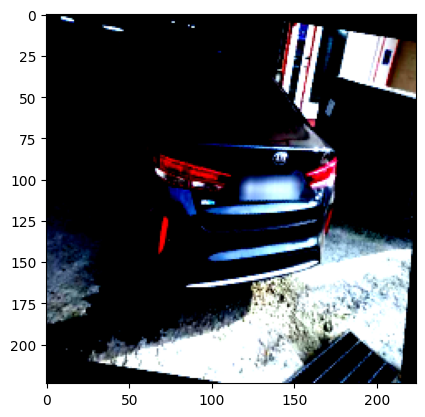

In [48]:
plt.imshow(images[0].permute(1, 2, 0))
plt.show()